###  MicroGrad demo

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
from micrograd.engine import Value
from micrograd.nn import MLP


In [11]:
np.random.seed(1337)
random.seed(1337)


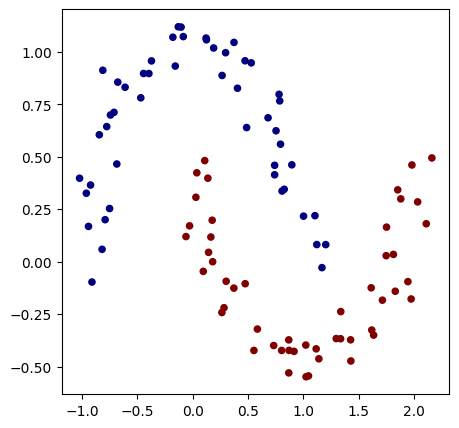

In [12]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


In [13]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [14]:
# loss function
def loss_helper(Xb, yb):
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    return scores, total_loss

# speed optimization if not batching
# this line is not needed when batching
cached_scores, cached_total_loss = loss_helper(X, y)

def loss(k, batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        # Since the inputs are always the same when not batching
        # the expression tree is re-used and just it's values are re-calculated.
        # This is much faster since it saves a lot of memory allocations.
        # On my system the difference is 2 minutes Vs 12 seconds.
        scores = cached_scores
        total_loss = cached_total_loss
        total_loss.refresh(k)
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
        scores, total_loss = loss_helper(Xb, yb)
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss(0)
print(total_loss, acc)


Value(data=0.8958441028683222, grad=0.0) 0.5


In [15]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss(k)
    
    # backward
    # this is done implicitely in refresh(), i.e. it's not needed if not batching
    # model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851133, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.36927933859765383, accuracy 84.0%
step 5 loss 0.31354548191852194, accuracy 86.0%
step 6 loss 0.2814234349772434, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658047, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.21560951851922952, accuracy 91.0%
step 13 loss 0.23090378446402735, accuracy 93.0%
step 14 loss 0.20152151227899445, accuracy 92.0%
step 15 loss 0.22574506279282222, accuracy 93.0%
step 16 loss 0.194479875962041, accuracy 92.0%
step 17 loss 0.21089496199246358, accuracy 93.0%
step 18 loss 0.1598307735630361, accuracy 94.0%
step 19 loss 0.18453748746883922, accuracy 93.0%
step 20 loss 0.18977522856087642, accur

(-1.548639298268643, 1.951360701731357)

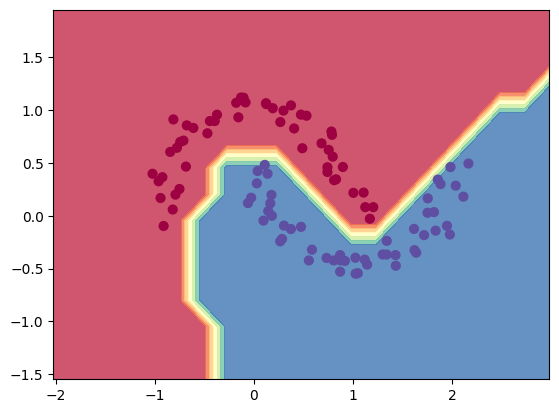

In [16]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
